In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


ModuleNotFoundError: No module named 'pydicom'

In [ ]:
import pylidc as pl
import os

from pylidc.utils import consensus
from pylidc.utils import volume_viewer

import matplotlib.cm as cm
import matplotlib.animation as manim

from skimage.measure import find_contours

from sqlalchemy import func

# 1. Carregar e Explorar Data

In [ ]:
#Carregar o ficheiro metadata que contém os diretórios de cada imagem
metadata = pd.read_csv('metadata.csv')
metadata.head()

In [2]:
rows = len(metadata)
rows

NameError: name 'metadata' is not defined

In [3]:
dir = metadata.loc[0]['File Location']
dir

NameError: name 'metadata' is not defined

In [4]:
#Abrir imagem com pydicom
CT_folder = os.path.join(dir)

ds = pydicom.read_file(os.path.join(CT_folder, '1-1.dcm'))
ds

NameError: name 'os' is not defined

In [5]:
#Pixel data
image = ds.pixel_array
image.shape

NameError: name 'ds' is not defined

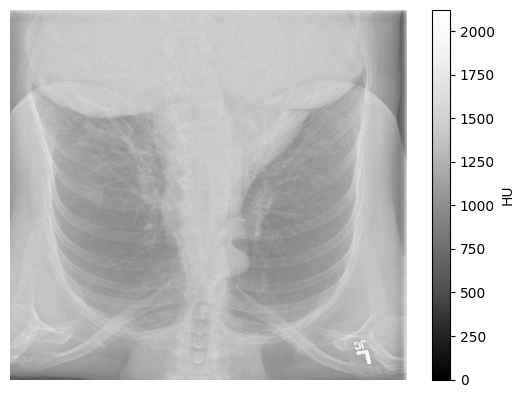

In [8]:
#Note that the image is a 2D array. Typically the pixel values are stored in a scaled format so we should adjust them:
image = ds.RescaleSlope * image + ds.RescaleIntercept
#Assim, a imagem fica em Housefield units outra vez

plt.pcolormesh(image, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

# 1.1. Pylidc

In [9]:
scans = pl.query(pl.Scan).all()
print(scans[0])
print(len(scans))

Scan(id=1,patient_id=LIDC-IDRI-0078)
1018


In [10]:
print(scans[0].patient_id,
      scans[0].pixel_spacing,
      scans[0].slice_thickness,
      scans[0].slice_spacing)

LIDC-IDRI-0078 0.65 3.0 3.0


In [11]:
print(len(scans[0].annotations))

13


In [12]:
scans[0].annotations

[Annotation(id=1,scan_id=1),
 Annotation(id=2,scan_id=1),
 Annotation(id=3,scan_id=1),
 Annotation(id=4,scan_id=1),
 Annotation(id=5,scan_id=1),
 Annotation(id=6,scan_id=1),
 Annotation(id=7,scan_id=1),
 Annotation(id=8,scan_id=1),
 Annotation(id=9,scan_id=1),
 Annotation(id=10,scan_id=1),
 Annotation(id=11,scan_id=1),
 Annotation(id=12,scan_id=1),
 Annotation(id=13,scan_id=1)]

In [13]:
nods = scans[0].cluster_annotations()

print("%s has %d nodules." % (scans[0], len(nods)))

for i,nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))

Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.
Nodule 4 has 4 annotations.


Loading dicom files ... This may take a moment.


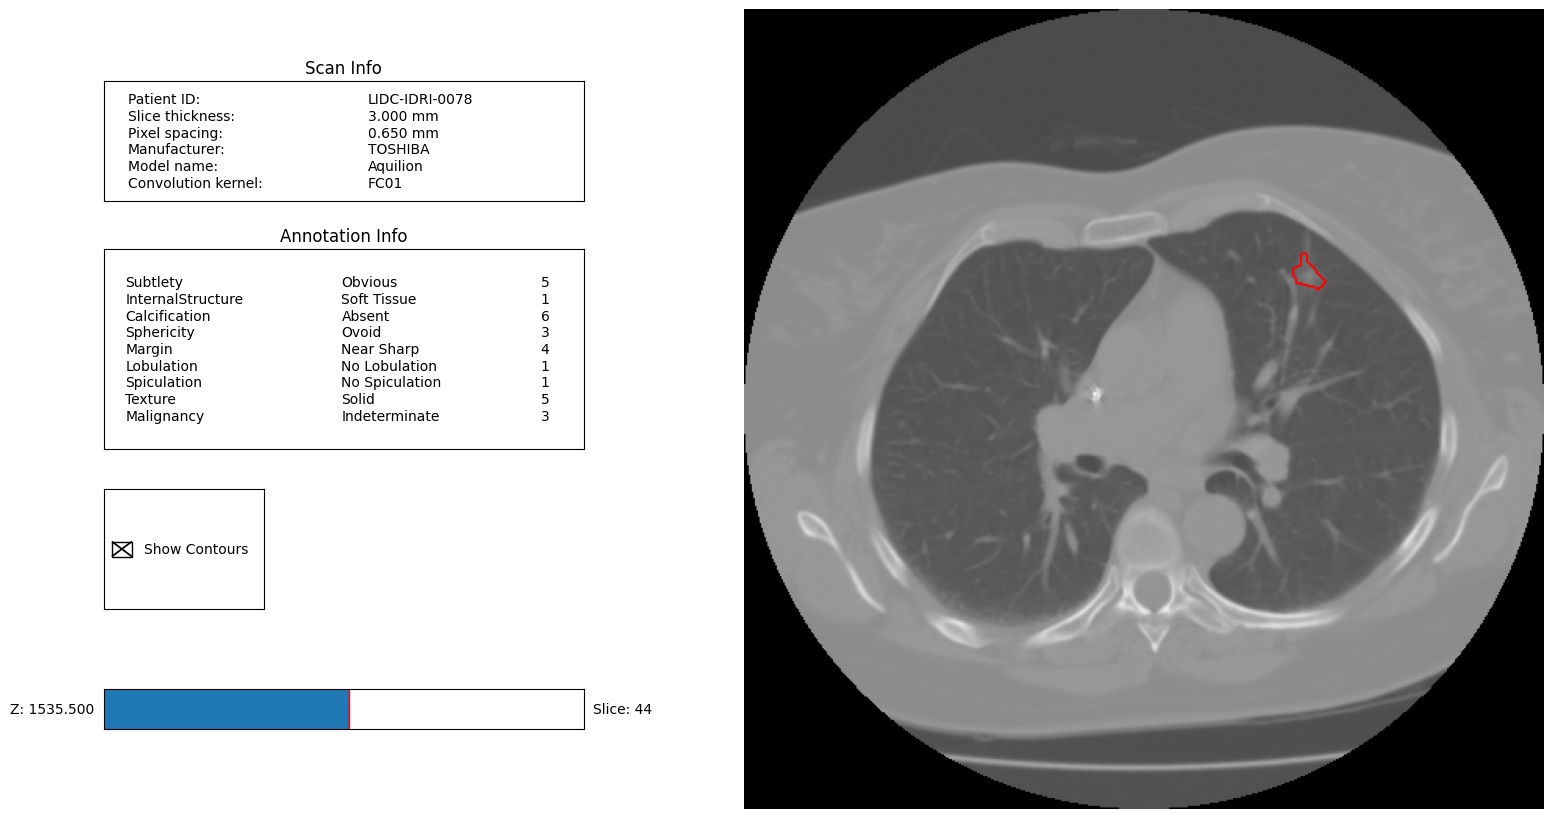

In [14]:
ann = pl.query(pl.Annotation).first()
ann.visualize_in_scan()

/home/claudia/anaconda3/lib/python3.9/_collections_abc.py:769: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
/home/claudia/Projeto1/lib/python3.9/site-packages/pylidc/Annotation.py:764: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  facecolors=plt.cm.cmap_d[cmap](t))


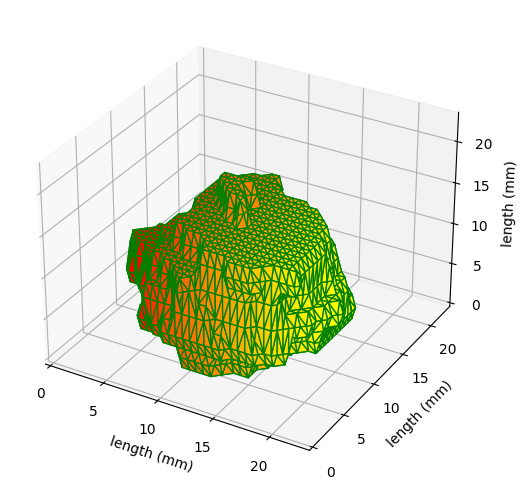

In [15]:
ann.visualize_in_3d(edgecolor='green', cmap='autumn')

Loading dicom files ... This may take a moment.


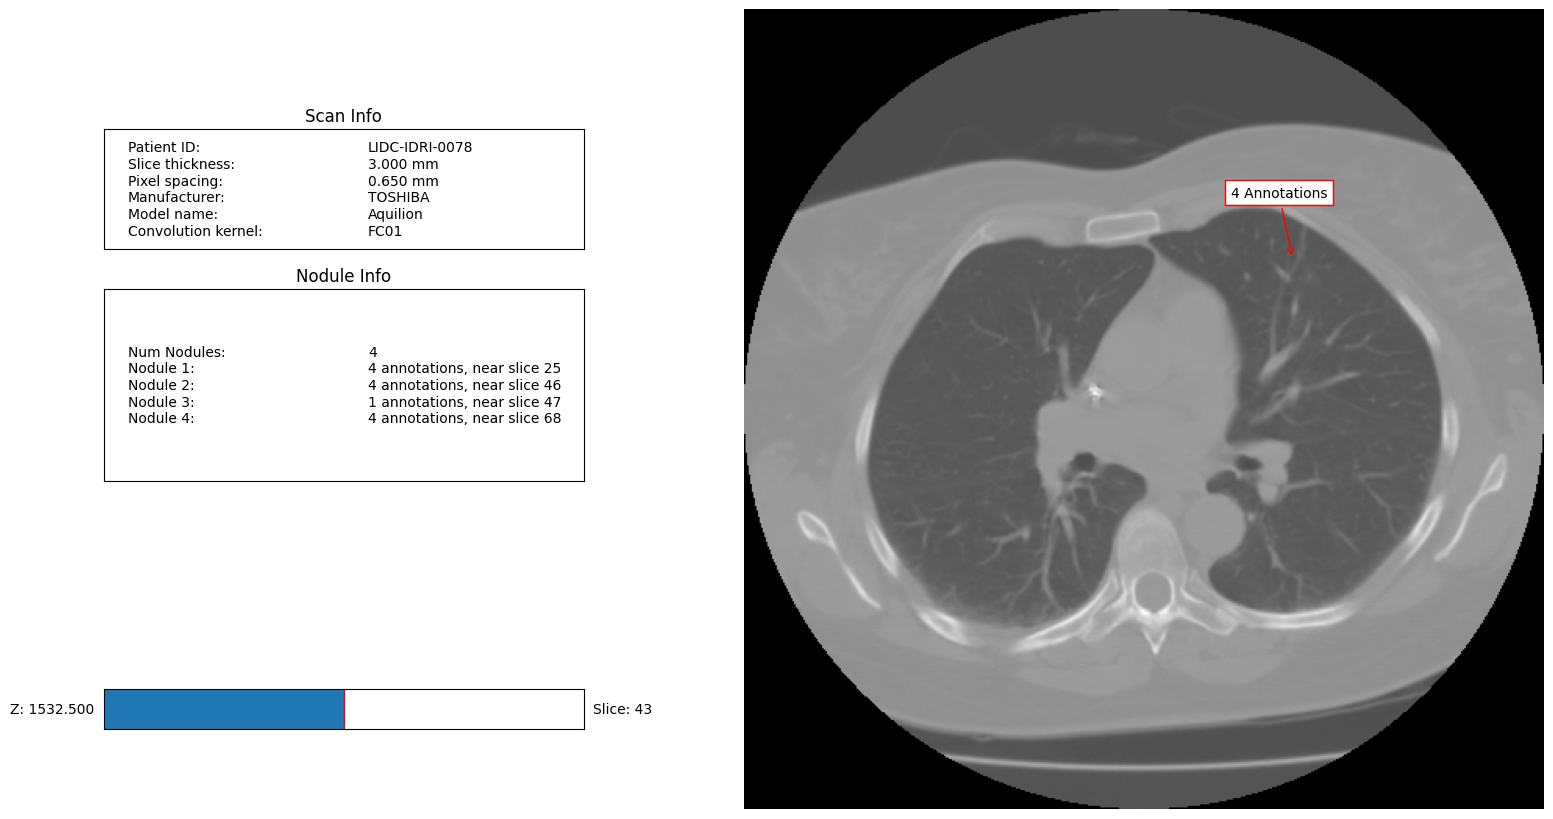

In [16]:
scans[0].visualize(annotation_groups=nods)

In [17]:
ann.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 


In [18]:
ann.feature_vals(return_str=False)

array([5, 1, 6, 3, 4, 1, 1, 5, 3])

In [19]:
len(ann.feature_vals(return_str=False))

9

In [20]:
print("%.2f, %.2f, %.2f" % (ann.diameter,ann.surface_area,ann.volume))

20.84, 1124.13, 2439.30


Loading dicom files ... This may take a moment.


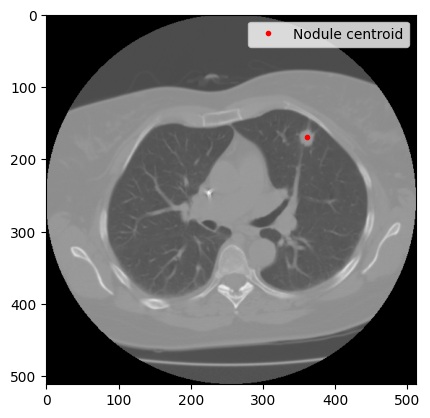

In [23]:
# Centróide
i,j,k = ann.centroid

vol = ann.scan.to_volume()

plt.imshow(vol[:,:,int(k)], cmap=plt.cm.gray)
plt.plot(j, i, '.r', label="Nodule centroid")
plt.legend()
plt.show()

Loading dicom files ... This may take a moment.


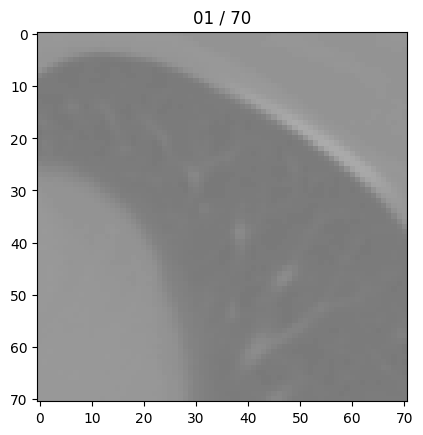

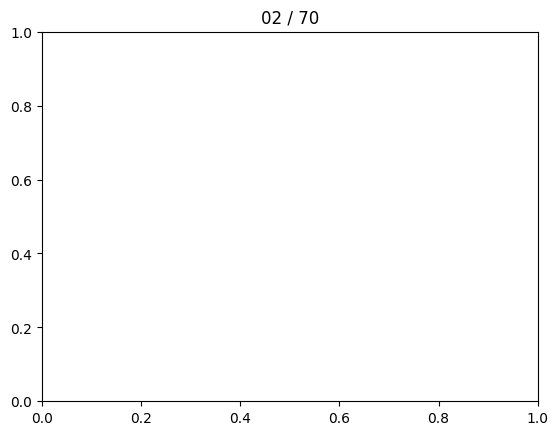

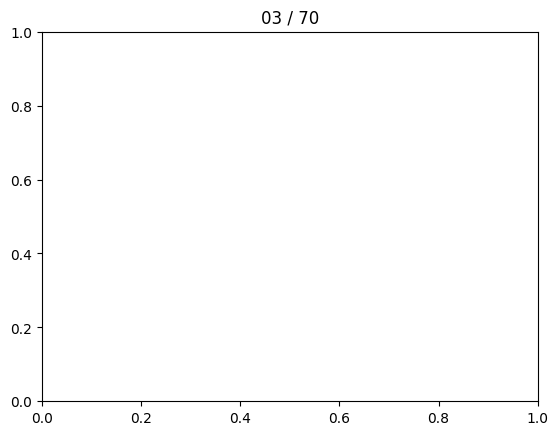

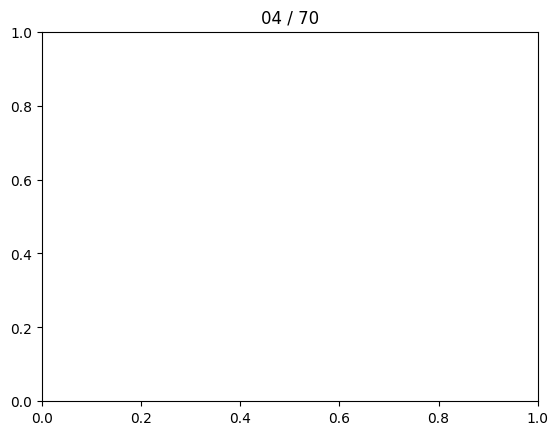

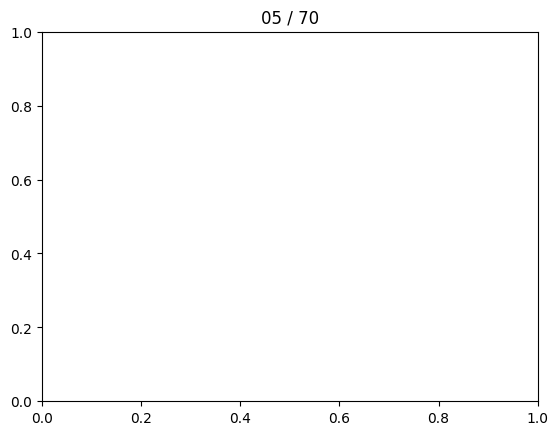

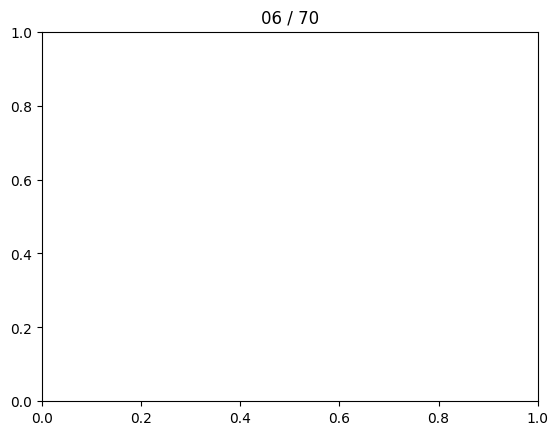

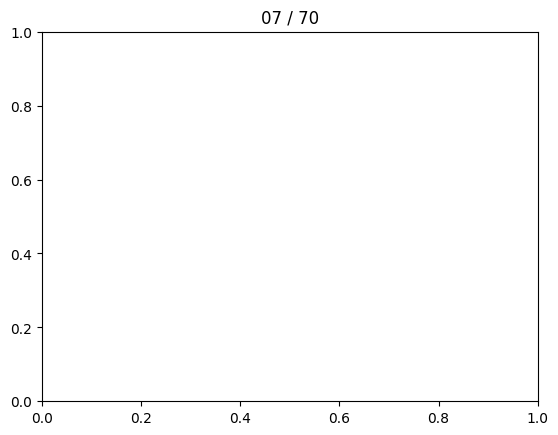

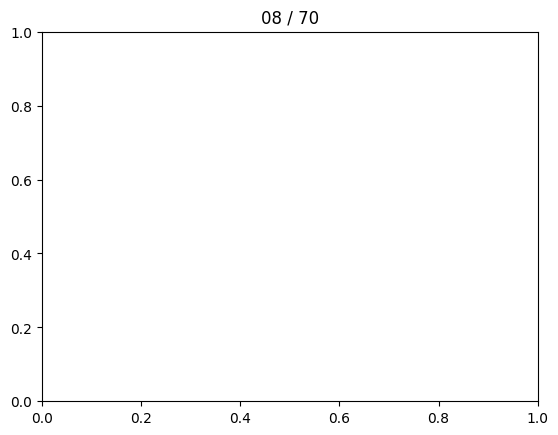

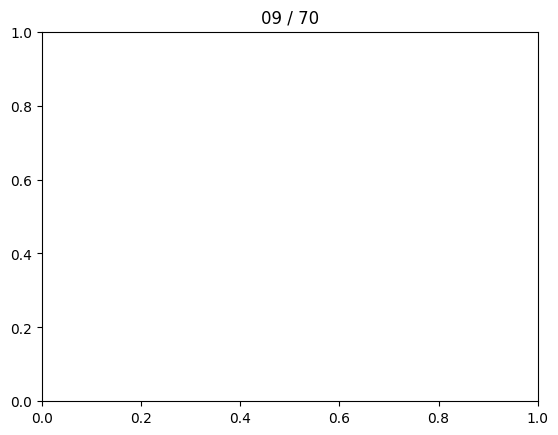

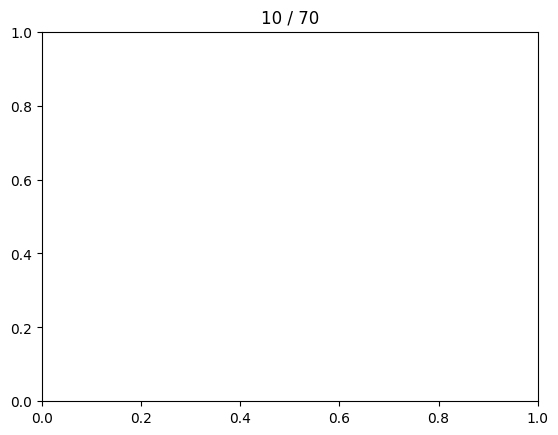

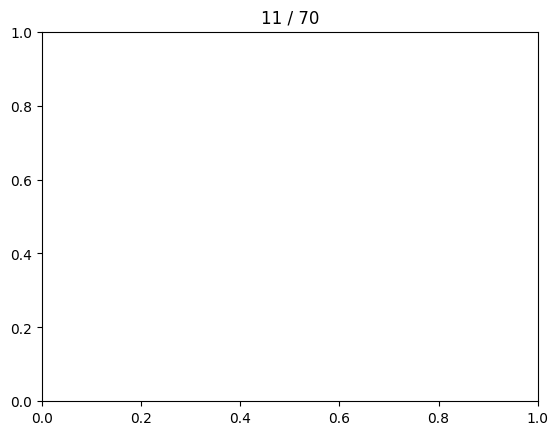

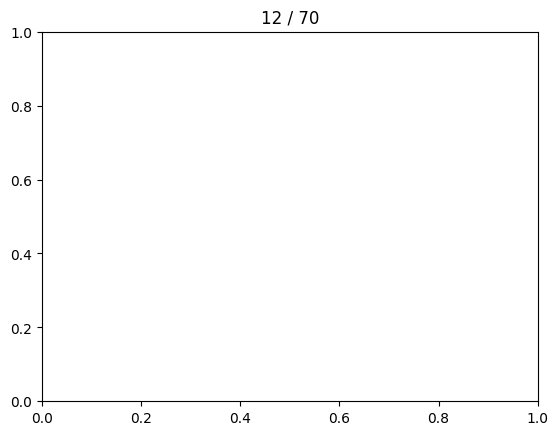

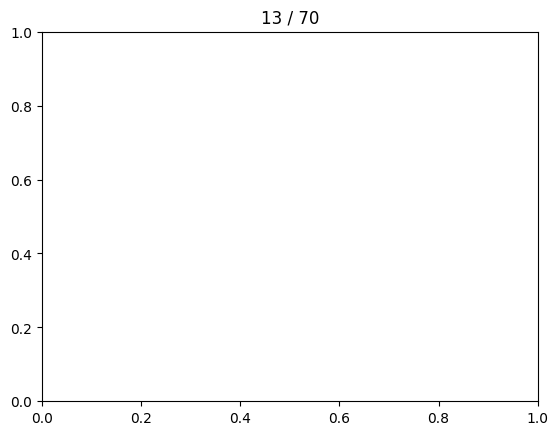

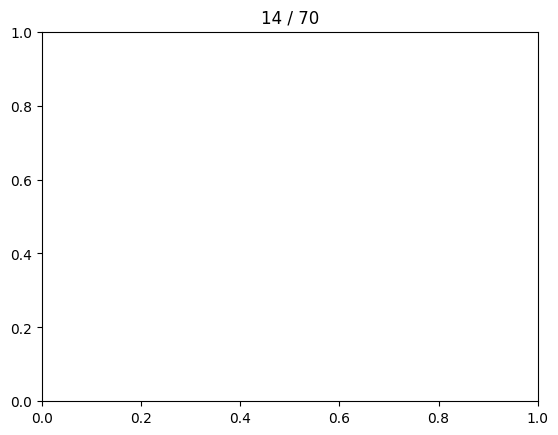

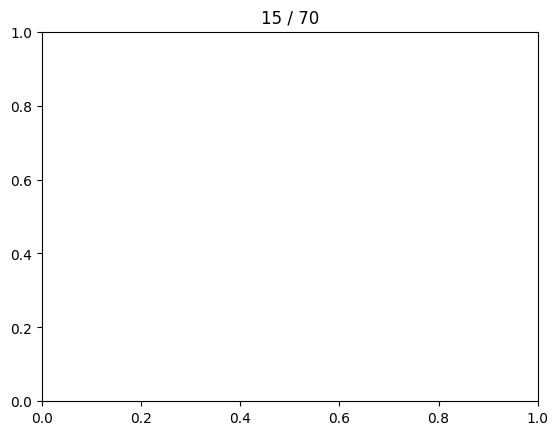

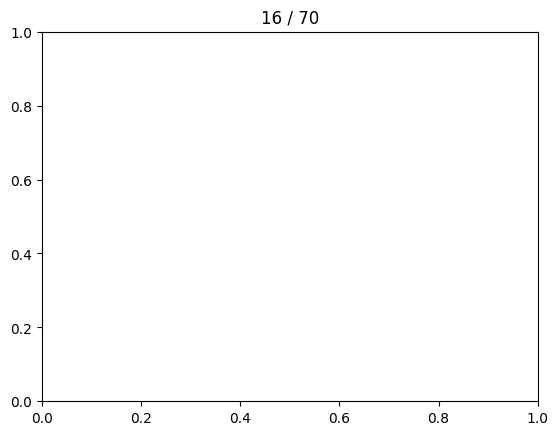

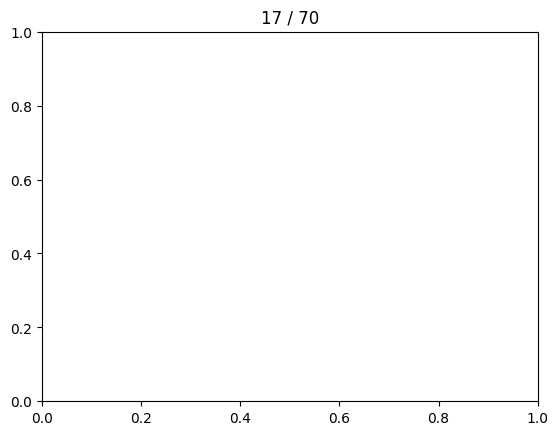

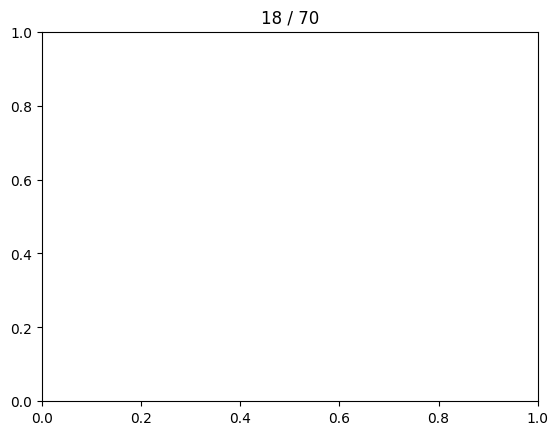

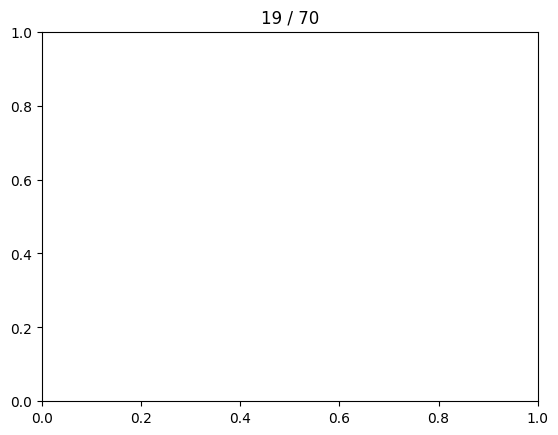

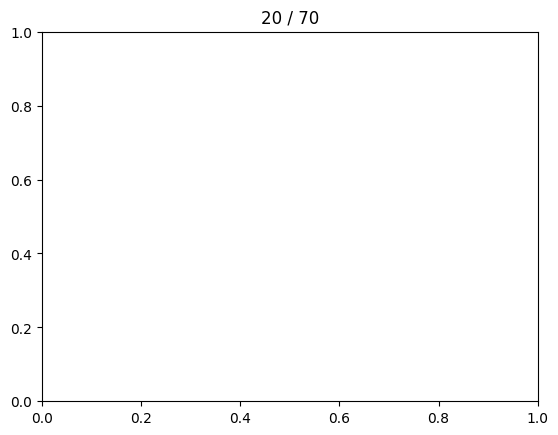

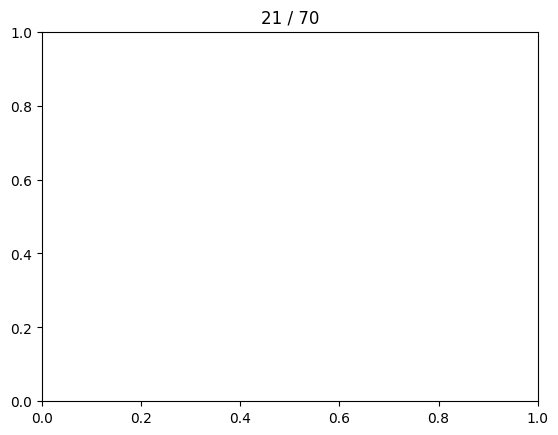

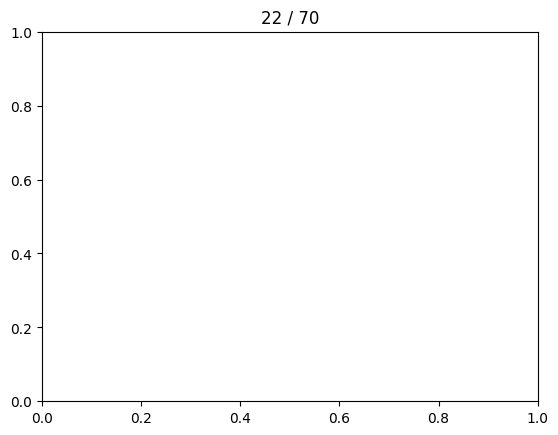

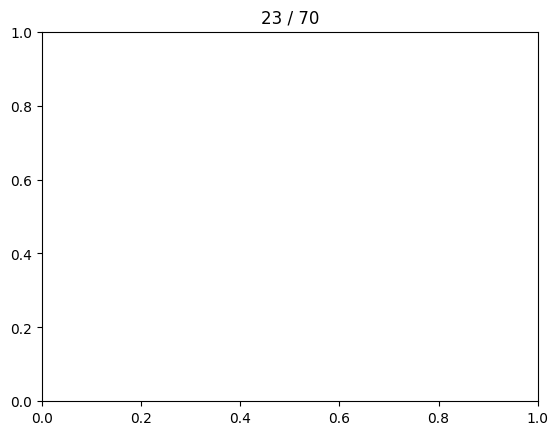

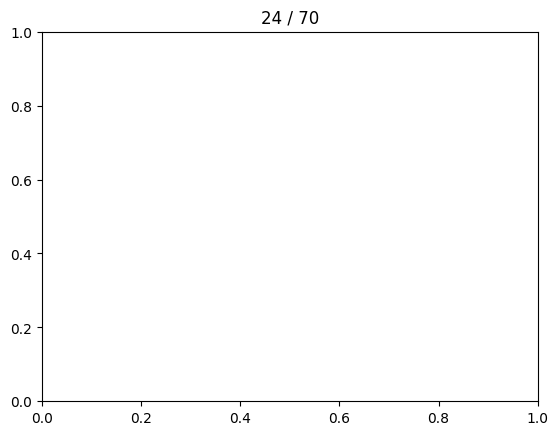

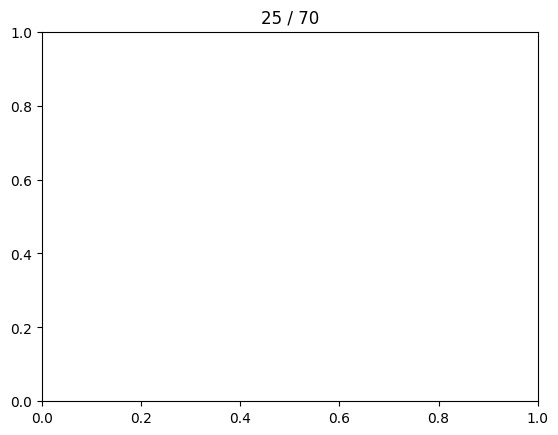

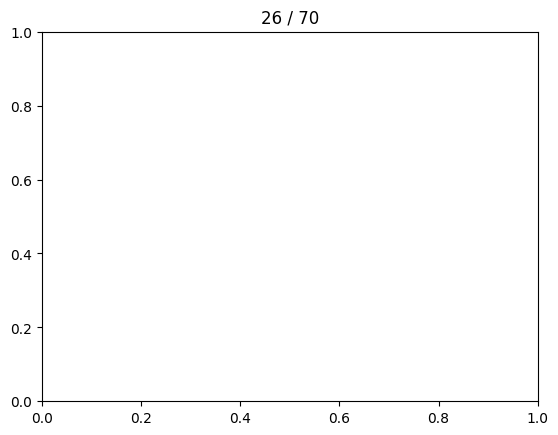

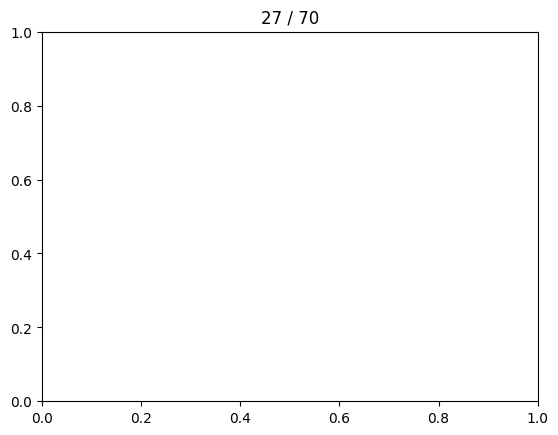

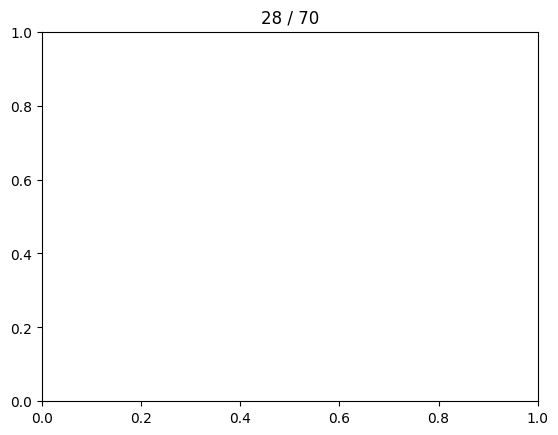

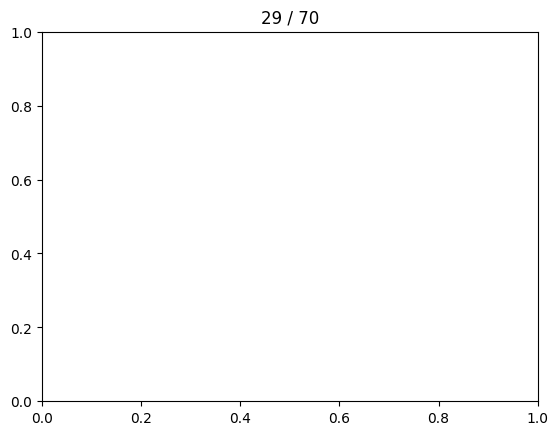

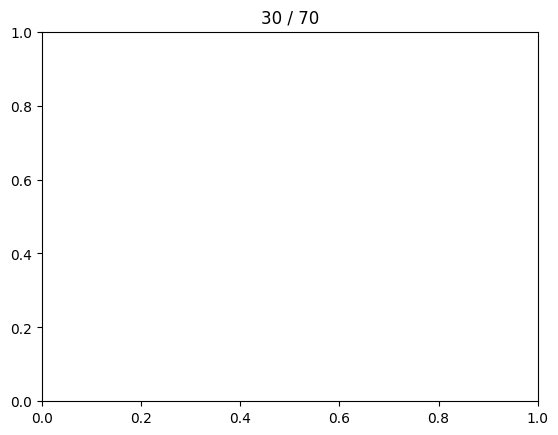

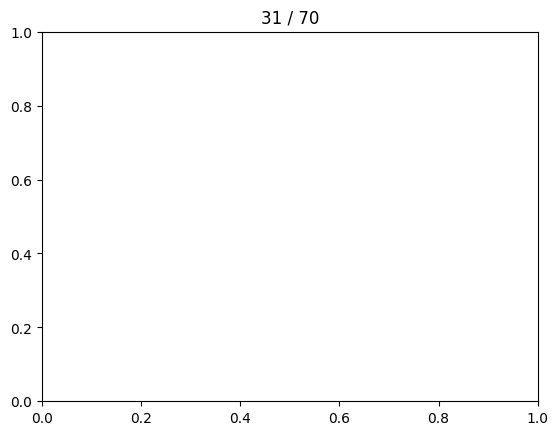

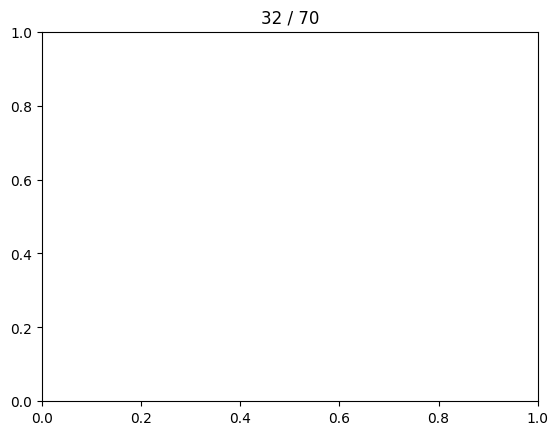

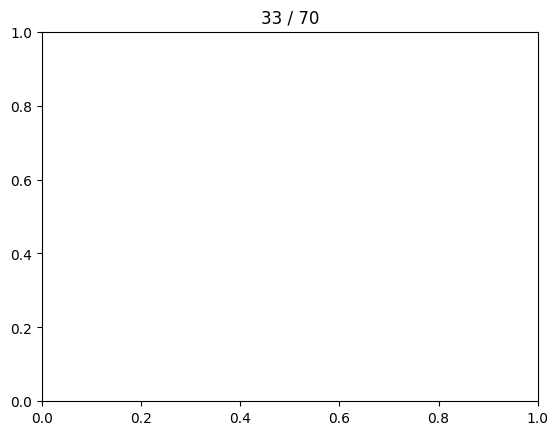

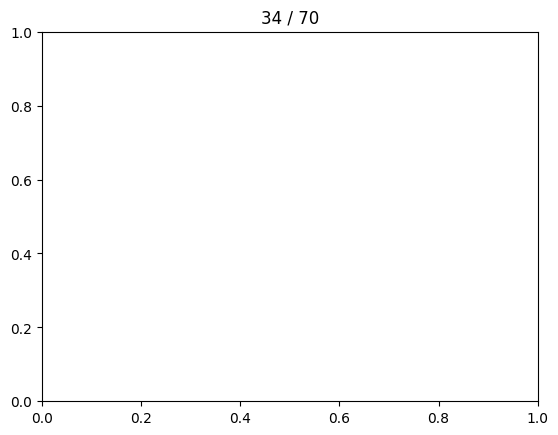

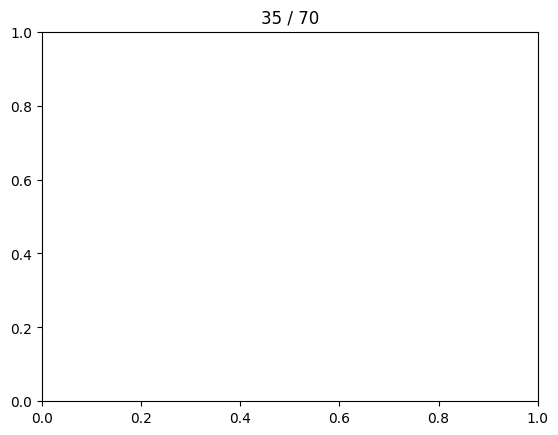

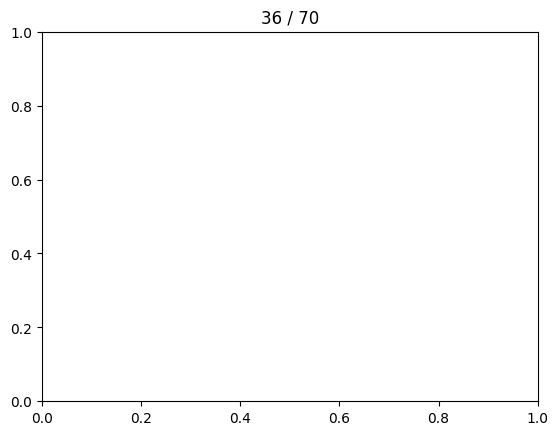

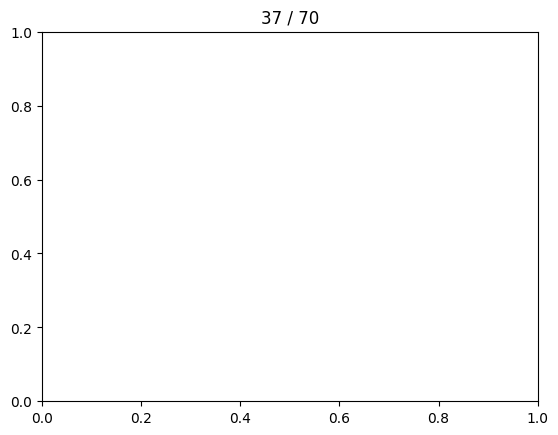

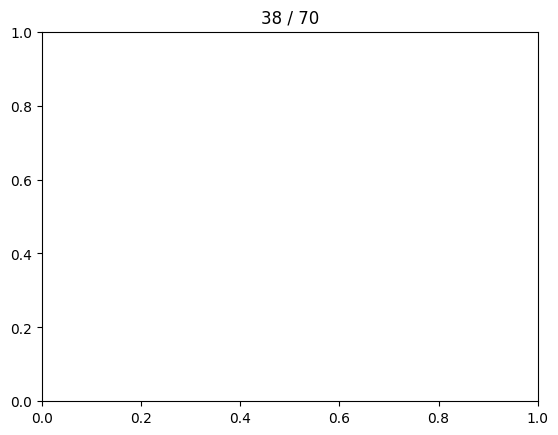

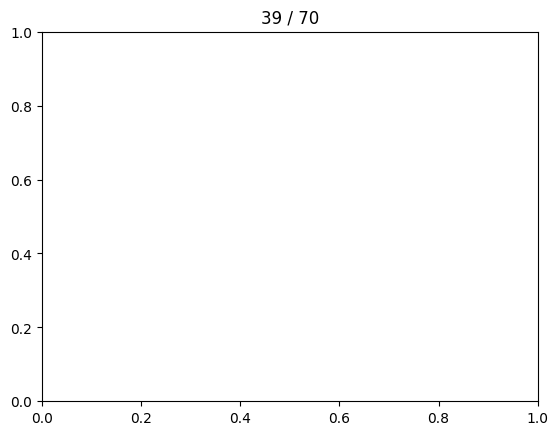

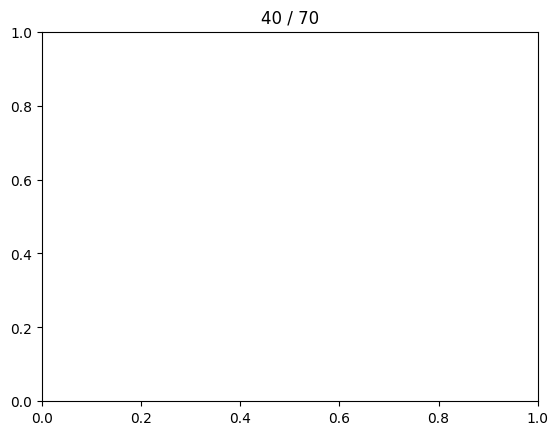

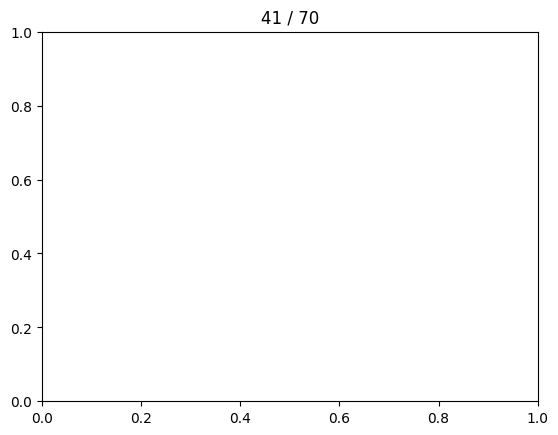

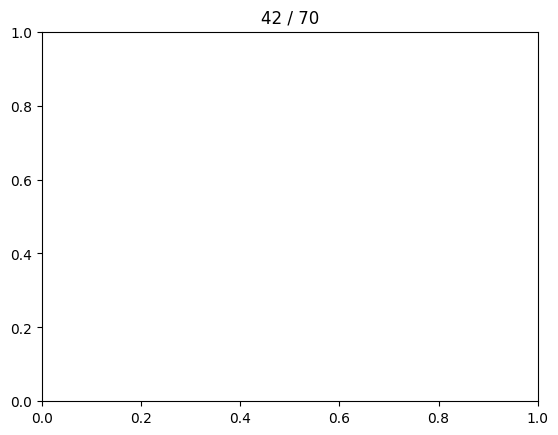

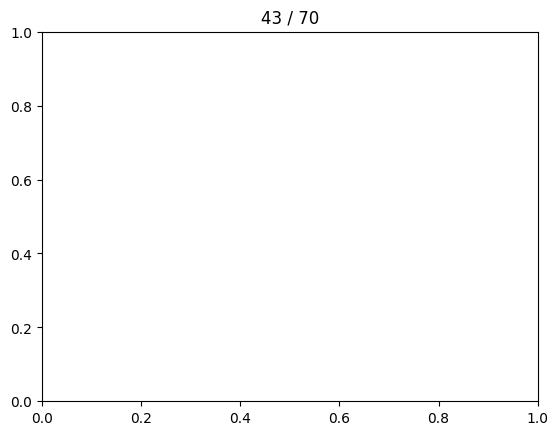

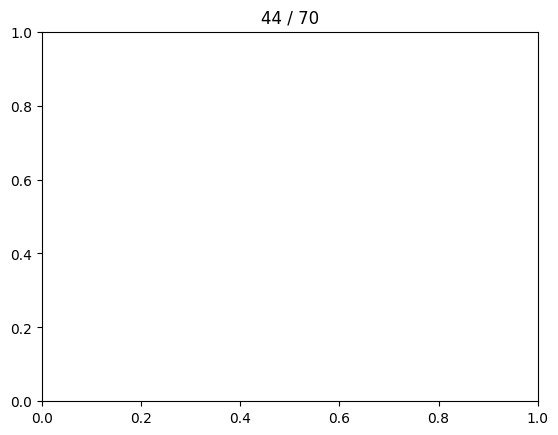

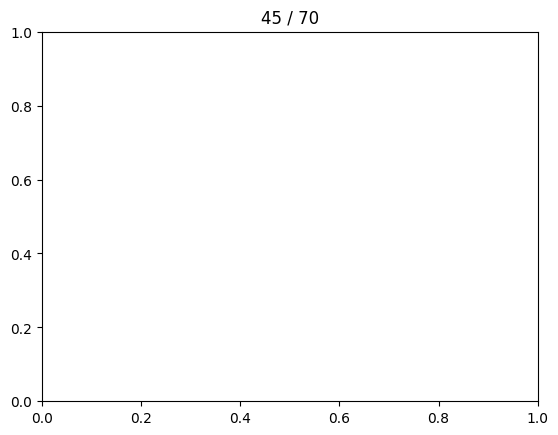

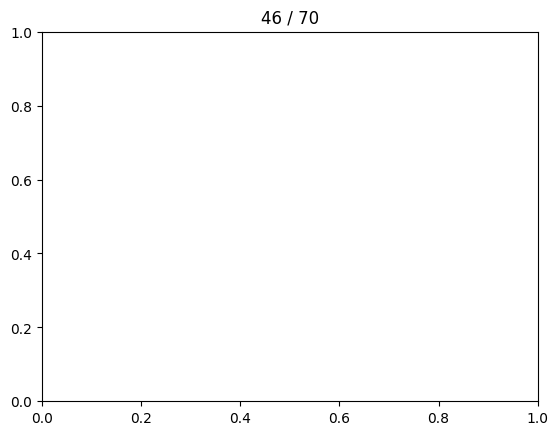

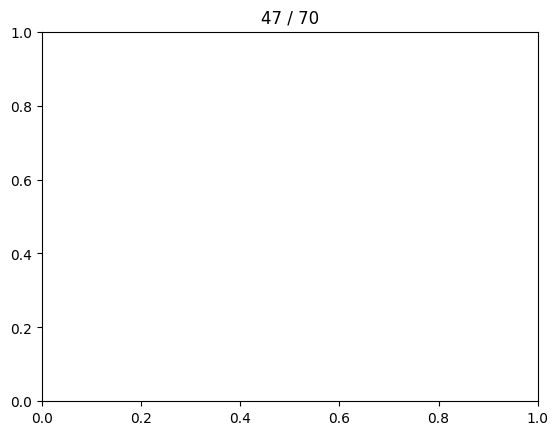

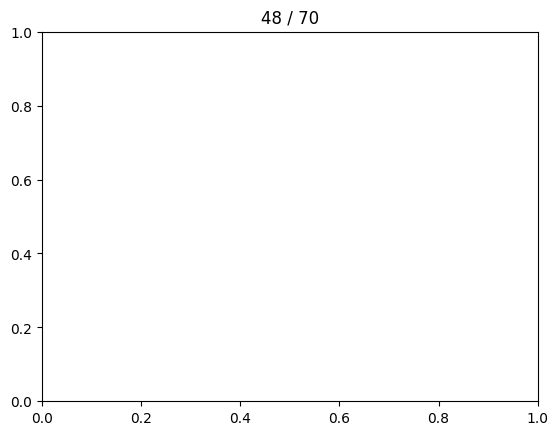

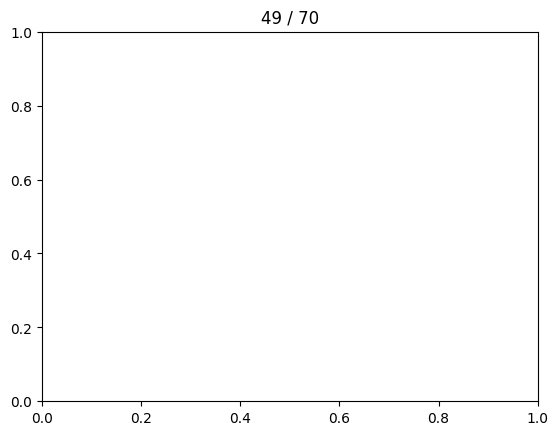

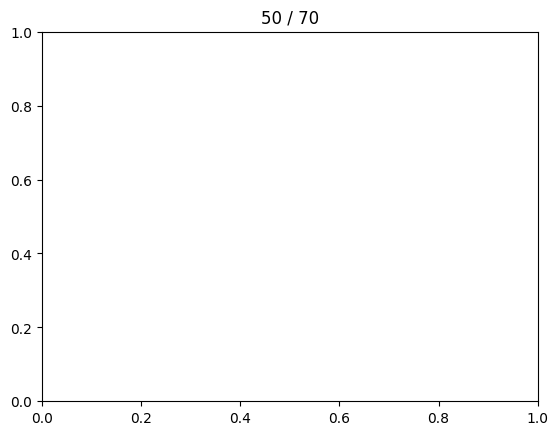

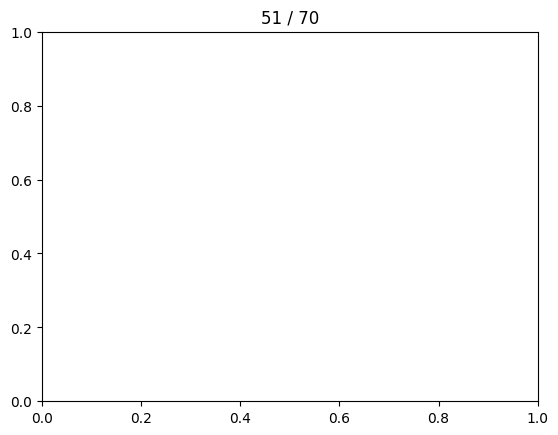

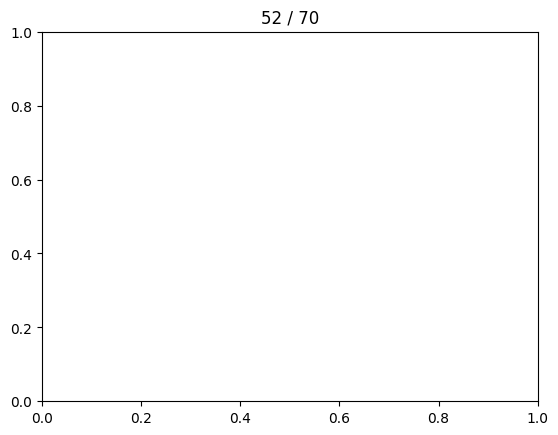

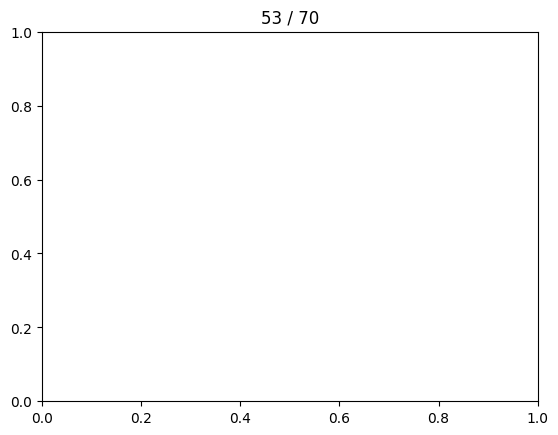

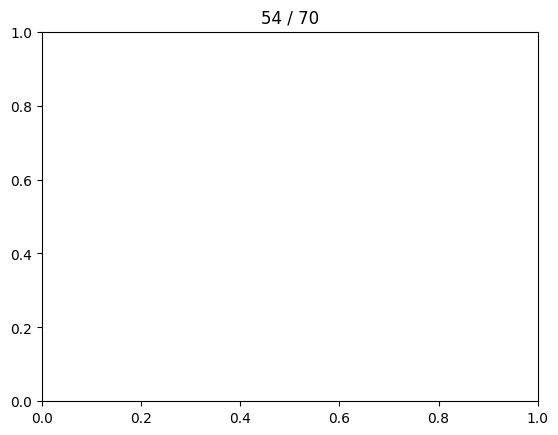

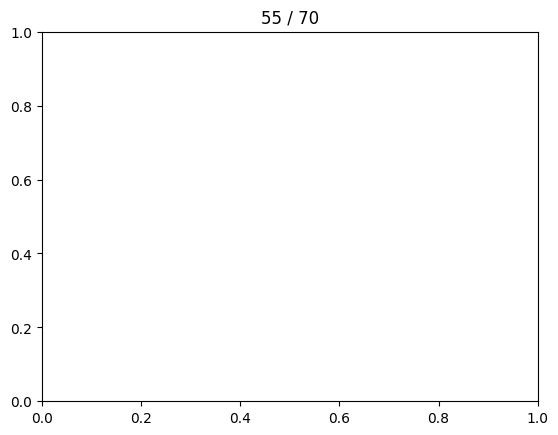

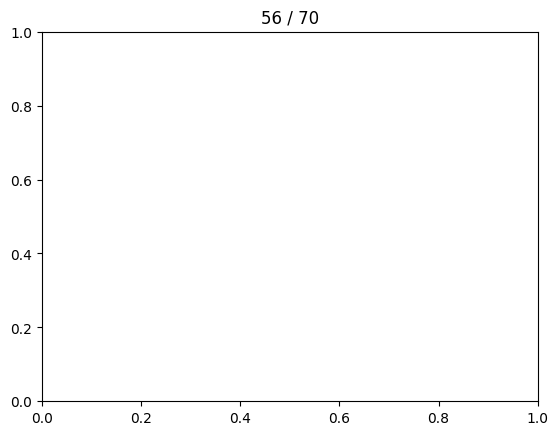

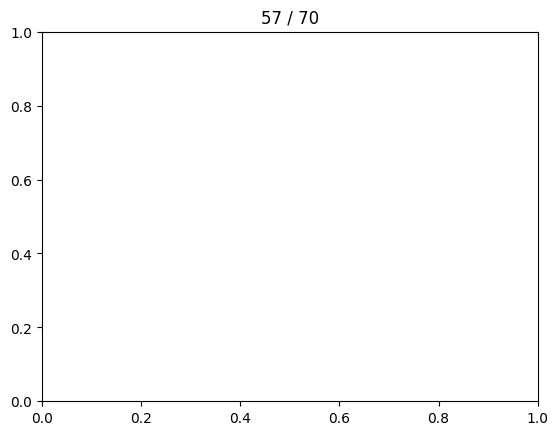

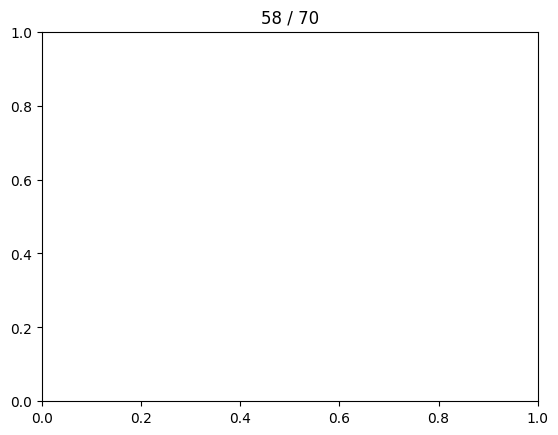

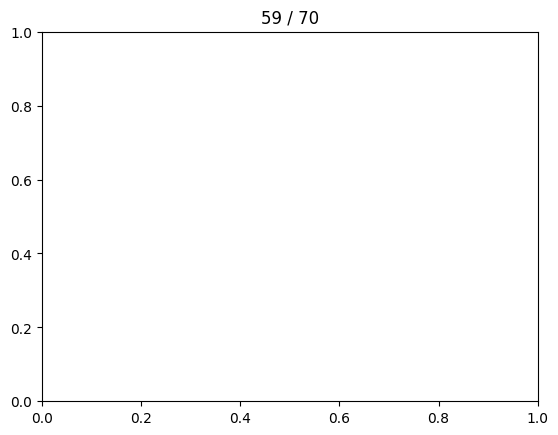

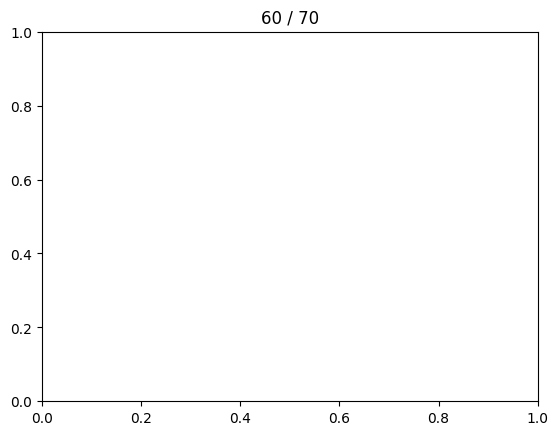

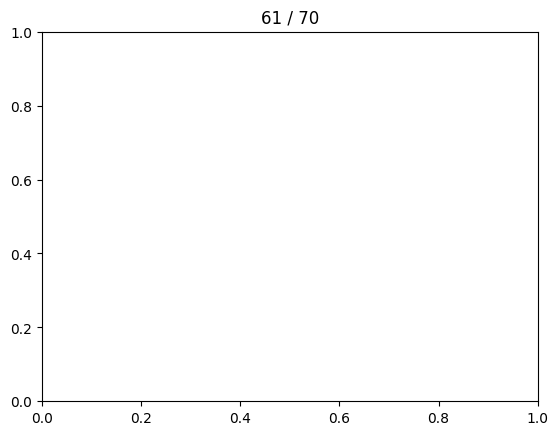

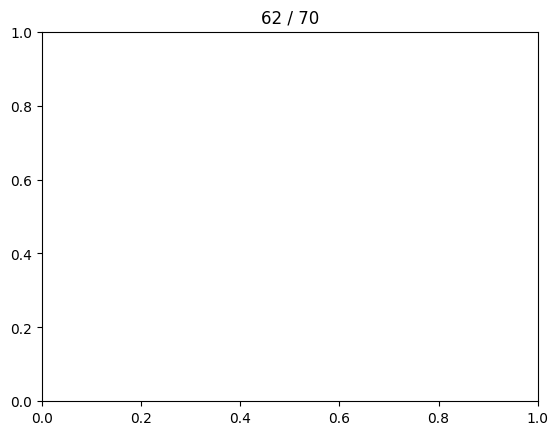

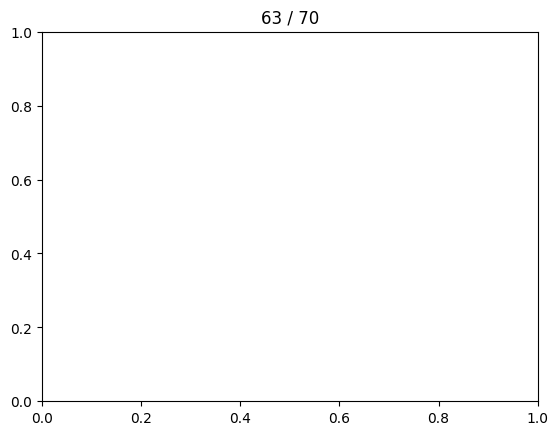

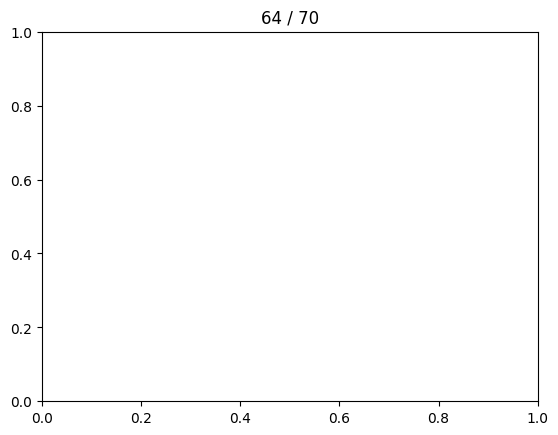

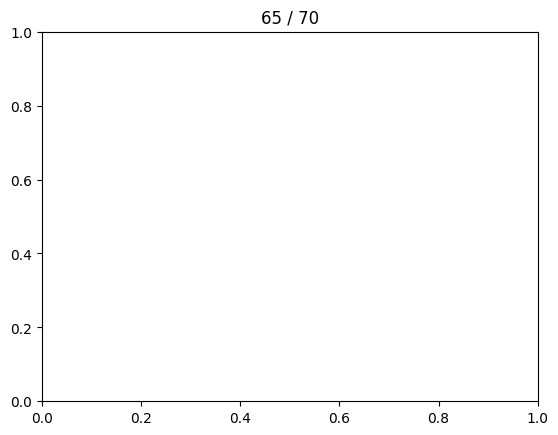

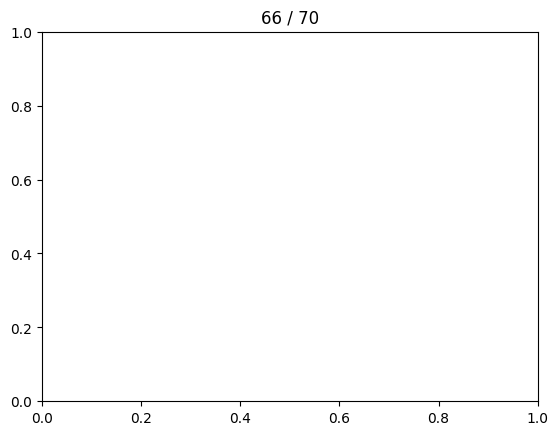

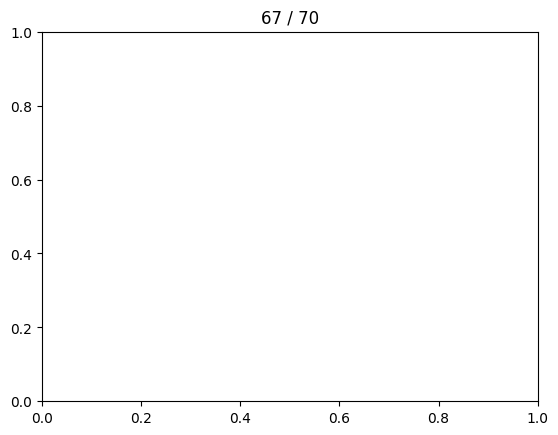

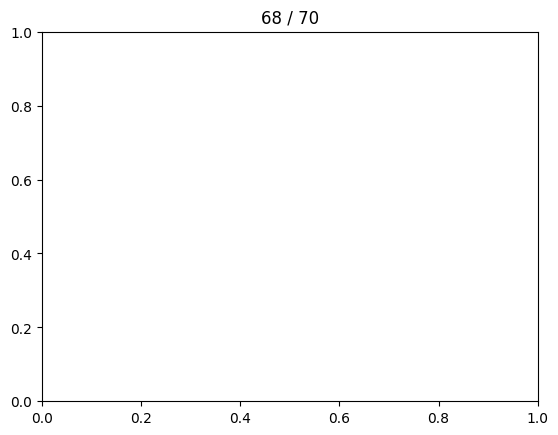

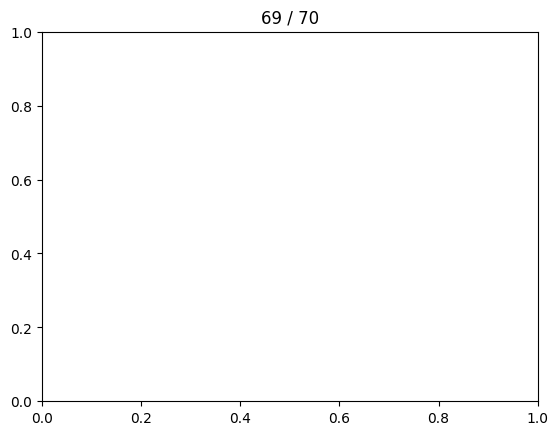

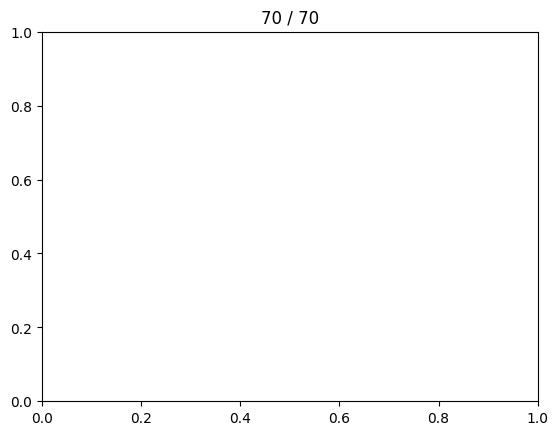

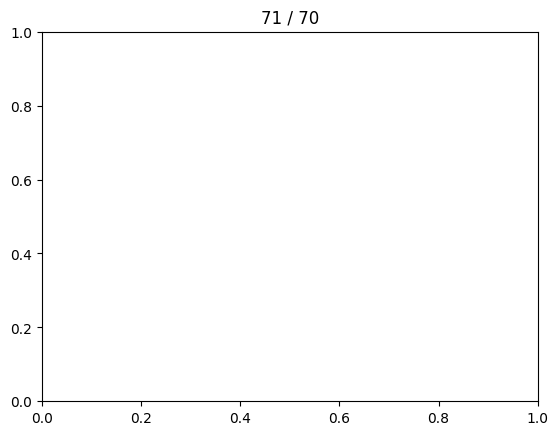

In [25]:
# uniform_cubic_resample
# resampled volumes will have uniform side length of 70mm and
# uniform voxel spacing of 1mm.
n = 70
vol,mask = ann.uniform_cubic_resample(n)

# Setup the plot.
img = plt.imshow(np.zeros((n+1, n+1)),
                 vmin=vol.min(), vmax=vol.max(),
                 cmap=plt.cm.gray)


# View all the resampled image volume slices.
for i in range(n+1):
    img.set_data(vol[:,:,i] * (mask[:,:,i]*0.6+0.2))

    plt.title("%02d / %02d" % (i+1, n))
    plt.pause(0.1)


Loading dicom files ... This may take a moment.


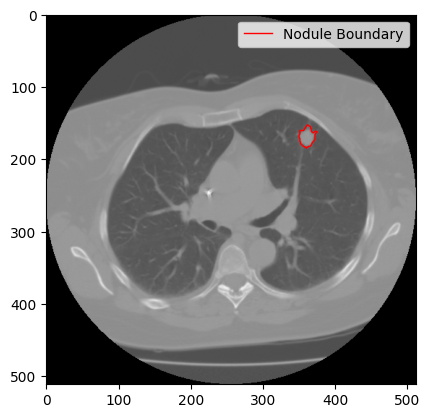

In [30]:
#Plotting a contour on top of the image volume
vol = ann.scan.to_volume()
con = ann.contours[3]

k = con.image_k_position
ii,jj = ann.contours[3].to_matrix(include_k=False).T

plt.imshow(vol[:,:,46], cmap=plt.cm.gray)
plt.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")
plt.legend()
plt.show()

Loading dicom files ... This may take a moment.


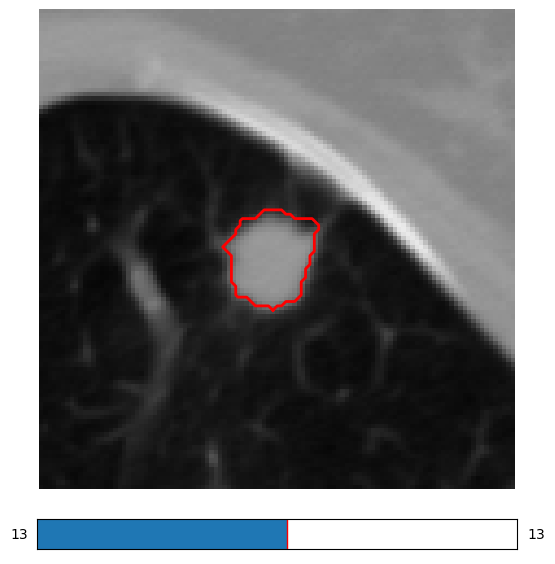

In [28]:
vol = ann.scan.to_volume()

padding = 70.0

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

volume_viewer(vol[bbox], mask, ls='-', lw=2, c='r')

# 2. Extrair Features

## 2.1. Testes

In [31]:
anns = pl.query(pl.Annotation)

In [32]:
a1= anns[0]
a1

Annotation(id=1,scan_id=1)

In [33]:
#Extrair 
print(a1.scan.patient_id)
print(a1._nodule_id)
# Extrair o id da anotação:
print(a1.id)
# Extrair o id do scan da anotação
print(a1.scan_id)

LIDC-IDRI-0078
3
1
1


In [34]:
a1.print_formatted_feature_table()

Feature              Meaning                    # 
-                    -                          - 
Subtlety           | Obvious                  | 5 
Internalstructure  | Soft Tissue              | 1 
Calcification      | Absent                   | 6 
Sphericity         | Ovoid                    | 3 
Margin             | Near Sharp               | 4 
Lobulation         | No Lobulation            | 1 
Spiculation        | No Spiculation           | 1 
Texture            | Solid                    | 5 
Malignancy         | Indeterminate            | 3 


In [36]:
print(a1.subtlety)
print(a1.internalStructure)
print(a1.spiculation)
print(a1.calcification)
#etc

5
1
1
6


In [37]:
print("%.2f, %.2f, %.2f" % (a1.diameter,
                            a1.surface_area,
                            a1.volume))

20.84, 1124.13, 2439.30


In [38]:
print(a1.diameter)
print(a1.surface_area)
print(a1.volume)

20.84058540444583
1124.1251774252464
2439.303749998624


## 2.2. Criar um Dataframe

## Testes:

In [39]:
df = pd.DataFrame(columns=['Id_Annotation','Id_Scan','Subtlety', 'Internalstructure', 'Calcification','Sphericity','Margin','Lobulation',
                           'Spiculation','Texture','Malignancy'])

In [40]:
df.columns

Index(['Id_Annotation', 'Id_Scan', 'Subtlety', 'Internalstructure',
       'Calcification', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation',
       'Texture', 'Malignancy'],
      dtype='object')

In [41]:
df

,Id_Annotation,Id_Scan,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy


In [42]:
ann = a1
row = [ann.id, ann.scan_id ,ann.subtlety,ann.internalStructure,ann.calcification,ann.sphericity,ann.margin,ann.lobulation,
           ann.spiculation,ann.texture,ann.malignancy]
type(row[0])

int

In [43]:
df.loc[0] = row
df

,Id_Annotation,Id_Scan,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
0,1,1,5,1,6,3,4,1,1,5,3


In [44]:
type(df.loc[0, 'Id_Scan'])

int

-------------------------------------------------------

In [45]:
df

,Id_Annotation,Id_Scan,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
0,1,1,5,1,6,3,4,1,1,5,3


## Funções:

##### Função que recebe uma anotação e transforma numa row para o dataframe:

In [46]:
def ann_row(ann):
    ids = np.array([ann.scan.patient_id, ann._nodule_id, ann.id, ann.scan_id], dtype = '<U14')
    features = ann.feature_vals()
    return(ids, features)    

##### Função que recebe uma lista de anotações e cria um dataframe

In [61]:
def anns_df(anotacoes):
    
    #Garantir que estamos a trabalhar com uma lista
    if  not isinstance(anotacoes, list):
        anotacoes = [anotacoes]
    
    #Criar 2 dataframes, uma para os ids e outro para as features:
    df_id = pd.DataFrame(columns = ["Patient_id", "Nodule_id", "Annotation_id", "Scan_id"])
    df_feat = pd.DataFrame(columns=['Subtlety', 'Internalstructure', 'Calcification','Sphericity','Margin','Lobulation',
                           'Spiculation','Texture','Malignancy'])
    
    for i, ann in enumerate(anotacoes):
        array_id, array_feat = ann_row(ann)
        df_id.loc[i] = array_id
        df_feat.loc[i] = array_feat

    df = pd.concat([df_id, df_feat], axis = 1)
    return(df)     

In [76]:
annotations = pl.query(pl.Annotation).all()
len(annotations)
anotacoes = annotations[:200]
data = anns_df(anotacoes)
data

,Patient_id,Nodule_id,Annotation_id,Scan_id,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
0,LIDC-IDRI-0078,3,1,1,5,1,6,3,4,1,1,5,3
1,LIDC-IDRI-0078,4,2,1,4,1,6,4,4,1,2,5,3
2,LIDC-IDRI-0078,6,3,1,5,1,4,3,5,2,3,5,4
3,LIDC-IDRI-0078,12321,4,1,5,1,6,4,2,4,1,5,5
4,LIDC-IDRI-0078,12325,5,1,4,1,6,4,2,3,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,LIDC-IDRI-0012,9,196,23,3,1,6,5,5,1,1,5,2
196,LIDC-IDRI-0012,10,197,23,3,1,6,5,5,1,1,5,2
197,LIDC-IDRI-0012,13,198,23,3,1,6,5,5,1,1,5,2
198,LIDC-IDRI-0012,14,199,23,3,1,6,5,5,1,1,5,2
